In [2]:
# The following code is based on https://neptune.ai/blog/arima-sarima-real-world-time-series-forecasting-guide

import pandas as pd
pd.options.display.max_columns = None
from datetime import datetime

In [2]:
def parser(s):
    return datetime.strptime(s, '%Y-%m-%d')

df = pd.read_csv('../../output/cut-data.csv', usecols=['dates', 'occupancy'], index_col=0, parse_dates=[0])
df.index.freq = 'D'
df

,occupancy
dates,
2017-05-01,139
2017-05-02,135
2017-05-03,133
2017-05-04,133
2017-05-05,135
...,...
2019-03-27,129
2019-03-28,141
2019-03-29,142


In [3]:
from statsmodels.tsa.stattools import adfuller

In [4]:
# augmented dickey-fuller test
# check if data is stationary
def check_stationarity(ts):
    dftest = adfuller(ts)
    adf = dftest[0]
    pvalue = dftest[1]
    critical_value = dftest[4]['5%']
    if (pvalue < 0.05) and (adf < critical_value):
        print('The series is stationary')
    else:
        print('The series is NOT stationary')

check_stationarity(df['occupancy'])

The series is stationary


In [4]:
import matplotlib.pyplot as plt

In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose

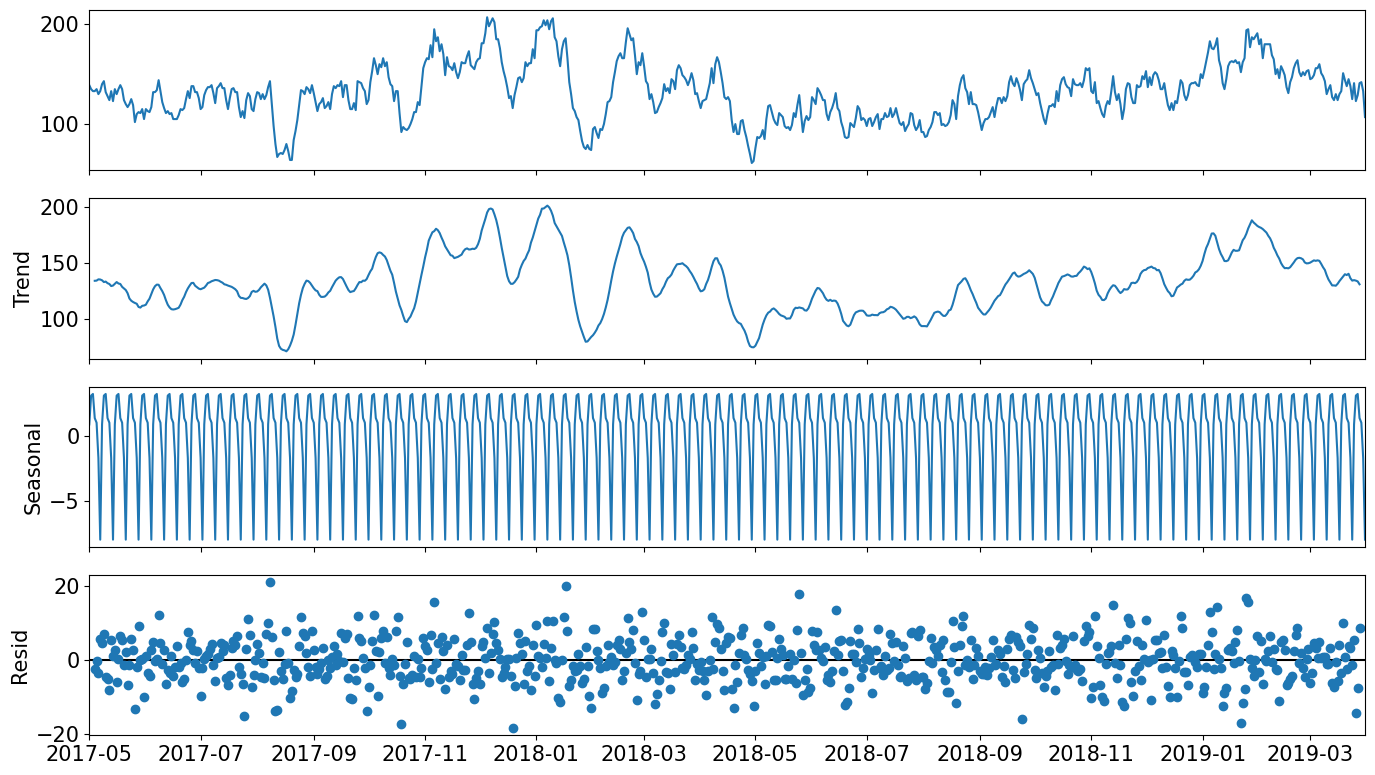

In [7]:
# because no stationarity in the form of a trend has been found using the adf-test, no differentiation is necessary
# before applying a seasonal decompose (https://www.kaggle.com/code/iamleonie/time-series-interpreting-acf-and-pacf)
plt.rc('figure',figsize=(14,8))
plt.rc('font',size=15)

result = seasonal_decompose(df,period=7)
fig = result.plot()

In [6]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [9]:
# Splitting data into test and training data

train_data = df.iloc[:-30]
test_data = df.iloc[-30:]

In [10]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

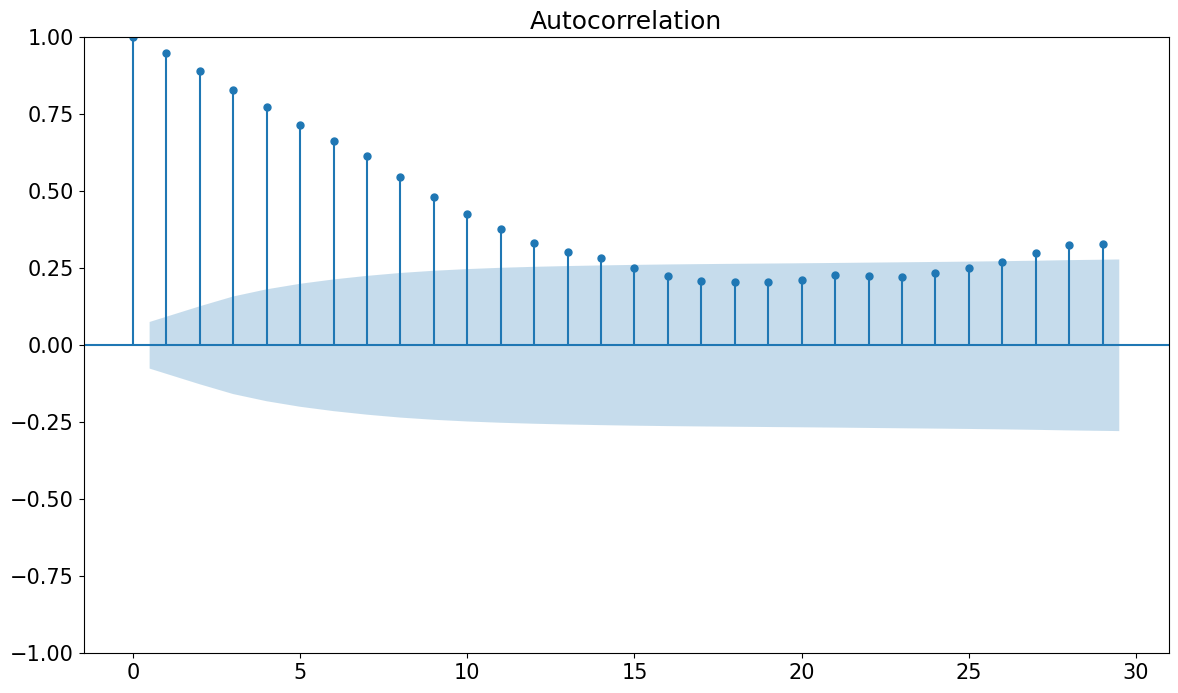

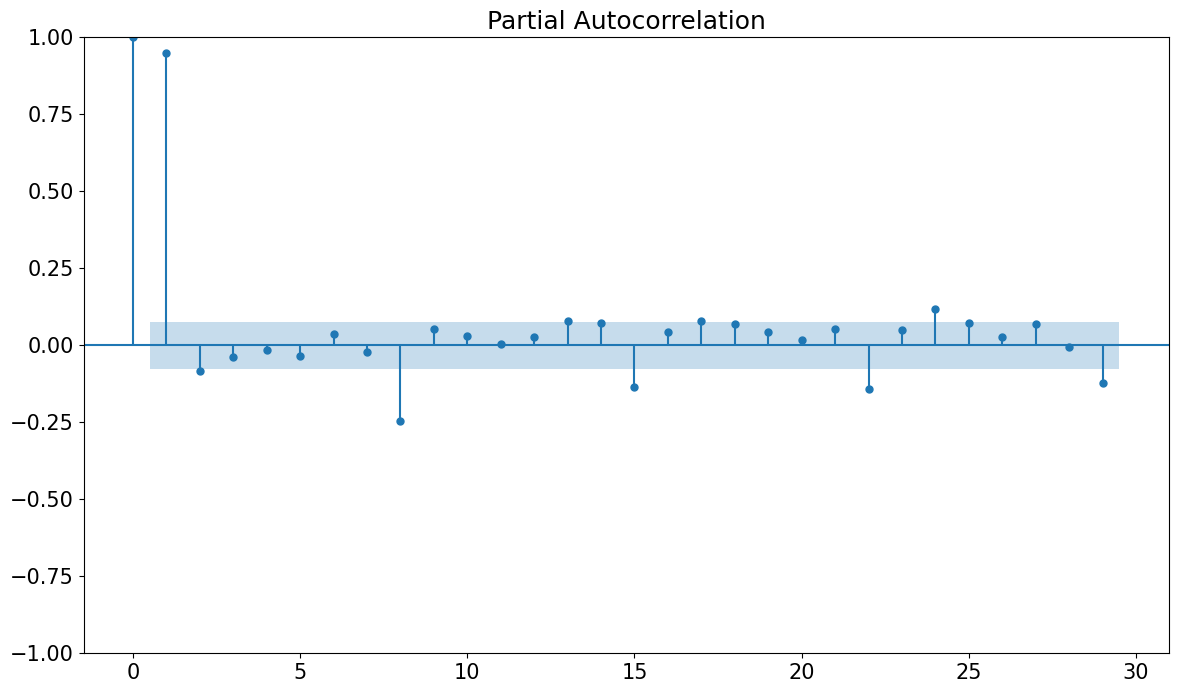

In [11]:
plot_acf(train_data['occupancy']);
plot_pacf(train_data['occupancy']);

In [12]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [13]:
# SARIMA
# p | P <= 2 because first 2 lags are meaningful according to PACF
# d | D = 0 because data is stationary (no trend)
# q | Q <= 15 because first 15 lags are meaningful according to ACF
# m = 7 because of seasonal plot and PACF
# Note, using the maximum values results in potential erros being highlighted by the framework.
# A more fitting approach in identifying the optimal parameters would be in this intance to take a look at the Geometric decay 
# (https://www.kaggle.com/code/iamleonie/time-series-interpreting-acf-and-pacf)
# More optimal parameters are being used further down inside of this notebook

p = 1
d = 0
q = 1
P = 2
D = 0
Q = 15
m = 7

sarima = SARIMAX(train_data['occupancy'],
                order=(p,d,q),
                seasonal_order=(P,D,Q,m))
model_fit_sarima = sarima.fit()

forecast_steps = 30
sarima_predictions_trained_data = model_fit_sarima.forecast(steps=forecast_steps)

/Users/alexandervalerian/Informatik/tha/intelligent-planning-of-care-staff/venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           20     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.80262D+00    |proj g|=  4.13987D-01

At iterate    5    f=  3.51329D+00    |proj g|=  4.64125D-02

At iterate   10    f=  3.49531D+00    |proj g|=  6.14265D-03

At iterate   15    f=  3.49396D+00    |proj g|=  1.07843D-03

At iterate   20    f=  3.49395D+00    |proj g|=  1.28914D-03

At iterate   25    f=  3.49347D+00    |proj g|=  9.29921D-03

At iterate   30    f=  3.49196D+00    |proj g|=  8.53466D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

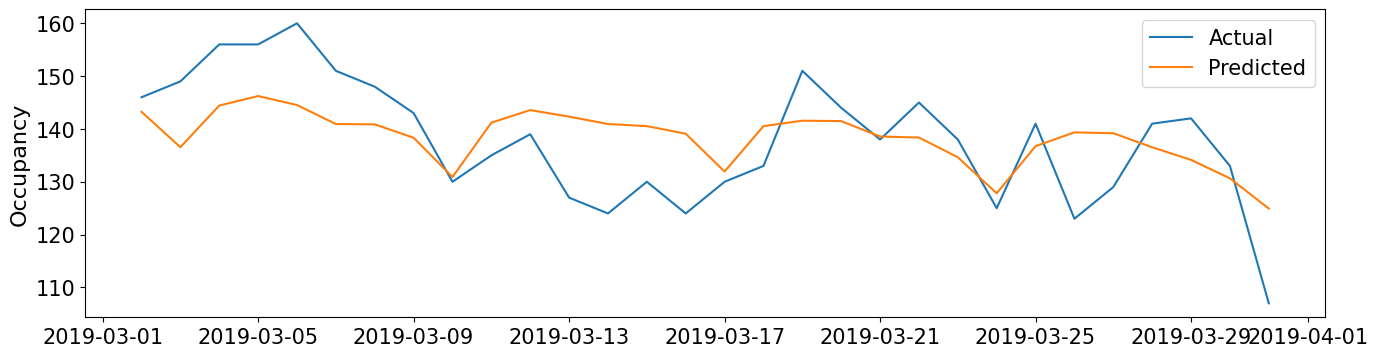

In [14]:
plt.figure(figsize=(16,4))
plt.plot(test_data, label="Actual") # No diff because we are working with stationary data (no trend)
plt.plot(sarima_predictions_trained_data, label="Predicted")
plt.ylabel('Occupancy', fontsize=16)
plt.legend()

In [12]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, root_mean_squared_error

In [16]:
# Calculation of RMSE and MAPE to interpret model quality
rmse = root_mean_squared_error(test_data[:30], sarima_predictions_trained_data)
mape = mean_absolute_percentage_error(test_data[:30], sarima_predictions_trained_data)
[rmse, mape]

[9.563145010803245, 0.05972724120367553]

In [13]:
# Forecast using time series split to receive a more accurate RMSE and MAPE using cross validation
# Adapted from https://www.geeksforgeeks.org/time-series-cross-validation/
from sklearn.model_selection import TimeSeriesSplit
import numpy as np

In [18]:
tscv = TimeSeriesSplit(n_splits=3, test_size=30)

In [19]:
rmse_scores = []
mape_scores = []

p = 1
d = 0
q = 1
P = 1
D = 0
Q = 15
m = 7

for train_index, test_index in tscv.split(df):
    train_data, test_data = df.iloc[train_index], df.iloc[test_index]
 
    model = SARIMAX(train_data['occupancy'],
                order=(p,d,q),
                seasonal_order=(P,D,Q,m))
    fitted_model = model.fit()
 
    predictions = fitted_model.forecast(steps=len(test_data))
 
    rmse = root_mean_squared_error(test_data, predictions)
    rmse_scores.append(rmse)

    mape = mean_absolute_percentage_error(test_data, predictions)
    mape_scores.append(mape)
 
    print(f'Root Mean Squared Error for current split: {rmse}')
    print(f'Mean Absolute  for current split: {rmse}')
 
# Calculate average Root Mean Squared Error across all splits
average_rmse = np.mean(rmse_scores)
print(f'Average Mean Squared Error across all splits: {average_rmse}')

# Calculate average Mean Absolute Percentage Error across all splits
average_mape = np.mean(mape_scores)
print(f'Average Mean Squared Error across all splits: {average_mape}')

/Users/alexandervalerian/Informatik/tha/intelligent-planning-of-care-staff/venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           19     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.92375D+00    |proj g|=  7.19330D-01

At iterate    5    f=  3.51934D+00    |proj g|=  4.98701D-02

At iterate   10    f=  3.49058D+00    |proj g|=  1.09532D-02

At iterate   15    f=  3.49006D+00    |proj g|=  2.52500D-03

At iterate   20    f=  3.48980D+00    |proj g|=  7.33452D-04

At iterate   25    f=  3.48951D+00    |proj g|=  1.03452D-02

At iterate   30    f=  3.48072D+00    |proj g|=  1.44963D-02

At iterate   35    f=  3.47937D+00    |proj g|=  1.81152D-03

At iterate   40    f=  3.47859D+00    |proj g|=  1.58729D-02

At iterate   45    f=  3.47784D+00    |proj g|=  1.02620D-03

At iterate   50    f=  3.47783D+00    |proj g|=  1.30596D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/Users/alexandervalerian/Informatik/tha/intelligent-planning-of-care-staff/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Root Mean Squared Error for current split: 32.420604693809885
Mean Absolute  for current split: 32.420604693809885


/Users/alexandervalerian/Informatik/tha/intelligent-planning-of-care-staff/venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/alexandervalerian/Informatik/tha/intelligent-planning-of-care-staff/venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           19     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.62290D+00    |proj g|=  2.56883D-01


 This problem is unconstrained.



At iterate    5    f=  3.53679D+00    |proj g|=  1.93660D-02

At iterate   10    f=  3.52869D+00    |proj g|=  1.67358D-02

At iterate   15    f=  3.52774D+00    |proj g|=  2.34778D-03

At iterate   20    f=  3.52667D+00    |proj g|=  6.05220D-03

At iterate   25    f=  3.52641D+00    |proj g|=  1.31260D-03

At iterate   30    f=  3.52634D+00    |proj g|=  6.83742D-03

At iterate   35    f=  3.52204D+00    |proj g|=  5.30122D-02

At iterate   40    f=  3.51041D+00    |proj g|=  1.67035D-02

At iterate   45    f=  3.50247D+00    |proj g|=  5.83138D-03


/Users/alexandervalerian/Informatik/tha/intelligent-planning-of-care-staff/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  3.50161D+00    |proj g|=  3.49742D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   19     50     62      1     0     0   3.497D-03   3.502D+00
  F =   3.5016132585251301     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Root Mean Squared Error for current split: 25.280742831027766
Mean Absolute  for current split: 25.280742831027766


/Users/alexandervalerian/Informatik/tha/intelligent-planning-of-care-staff/venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           19     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.93245D+00    |proj g|=  7.34603D-01


 This problem is unconstrained.



At iterate    5    f=  3.52476D+00    |proj g|=  4.95749D-02

At iterate   10    f=  3.49633D+00    |proj g|=  4.80376D-03

At iterate   15    f=  3.49572D+00    |proj g|=  8.00995D-03

At iterate   20    f=  3.49558D+00    |proj g|=  5.94531D-04

At iterate   25    f=  3.49474D+00    |proj g|=  1.42298D-02

At iterate   30    f=  3.48655D+00    |proj g|=  1.61970D-02

At iterate   35    f=  3.48565D+00    |proj g|=  3.42552D-03

At iterate   40    f=  3.48549D+00    |proj g|=  3.48193D-03

At iterate   45    f=  3.48543D+00    |proj g|=  1.06373D-04


/Users/alexandervalerian/Informatik/tha/intelligent-planning-of-care-staff/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  3.48543D+00    |proj g|=  5.92320D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   19     50     66      1     0     0   5.923D-04   3.485D+00
  F =   3.4854308086063535     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Root Mean Squared Error for current split: 9.635665193021051
Mean Absolute  for current split: 9.635665193021051
Average Mean Squared Error across all splits: 22.4456709059529
Average Mean Squared Error across all splits: 0.12120797747661725


In [20]:
from pmdarima.arima import auto_arima

In [21]:
# Calculating optimal SARIMA parameters using auto_arima. Here, the parameter m needs to be manually set
model = auto_arima(train_data['occupancy'], 
                   start_p=0, start_q=0, max_p=2, max_q=15,
                   test='adf',
                   seasonal=True,
                   m=7,
                   trace=True,
                   stepwise=False)

 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=6364.720, Time=0.02 sec
 ARIMA(0,0,0)(0,0,1)[7] intercept   : AIC=6081.613, Time=0.37 sec
 ARIMA(0,0,0)(0,0,2)[7] intercept   : AIC=6027.578, Time=0.64 sec
 ARIMA(0,0,0)(1,0,0)[7] intercept   : AIC=6048.724, Time=0.18 sec
 ARIMA(0,0,0)(1,0,1)[7] intercept   : AIC=inf, Time=0.43 sec
 ARIMA(0,0,0)(1,0,2)[7] intercept   : AIC=6029.247, Time=1.23 sec
 ARIMA(0,0,0)(2,0,0)[7] intercept   : AIC=6035.285, Time=0.84 sec
 ARIMA(0,0,0)(2,0,1)[7] intercept   : AIC=inf, Time=1.11 sec
 ARIMA(0,0,0)(2,0,2)[7] intercept   : AIC=inf, Time=1.46 sec
 ARIMA(0,0,1)(0,0,0)[7] intercept   : AIC=5703.431, Time=0.07 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=5522.131, Time=0.44 sec
 ARIMA(0,0,1)(0,0,2)[7] intercept   : AIC=5497.000, Time=0.79 sec
 ARIMA(0,0,1)(1,0,0)[7] intercept   : AIC=5490.086, Time=0.40 sec
 ARIMA(0,0,1)(1,0,1)[7] intercept   : AIC=inf, Time=0.99 sec
 ARIMA(0,0,1)(1,0,2)[7] intercept   : AIC=5494.806, Time=1.51 sec
 ARIMA(0,0,1)(2,0,0)[7] interc

In [22]:
# SARIMA prediction using optimal parameters

sarima = SARIMAX(train_data['occupancy'],
                order=(2,0,0),
                seasonal_order=(1,0,2,7))
model_fit_sarima = sarima.fit()

forecast_steps = 30
sarima_predictions_trained_data = model_fit_sarima.forecast(steps=forecast_steps)

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.01194D+00    |proj g|=  7.87353D-01

At iterate    5    f=  3.52722D+00    |proj g|=  8.60961D-02

At iterate   10    f=  3.51200D+00    |proj g|=  7.28085D-03

At iterate   15    f=  3.51077D+00    |proj g|=  2.38346D-02

At iterate   20    f=  3.50366D+00    |proj g|=  8.75932D-03

At iterate   25    f=  3.50067D+00    |proj g|=  6.47993D-03

At iterate   30    f=  3.49548D+00    |proj g|=  2.59638D-02

At iterate   35    f=  3.49347D+00    |proj g|=  1.11190D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

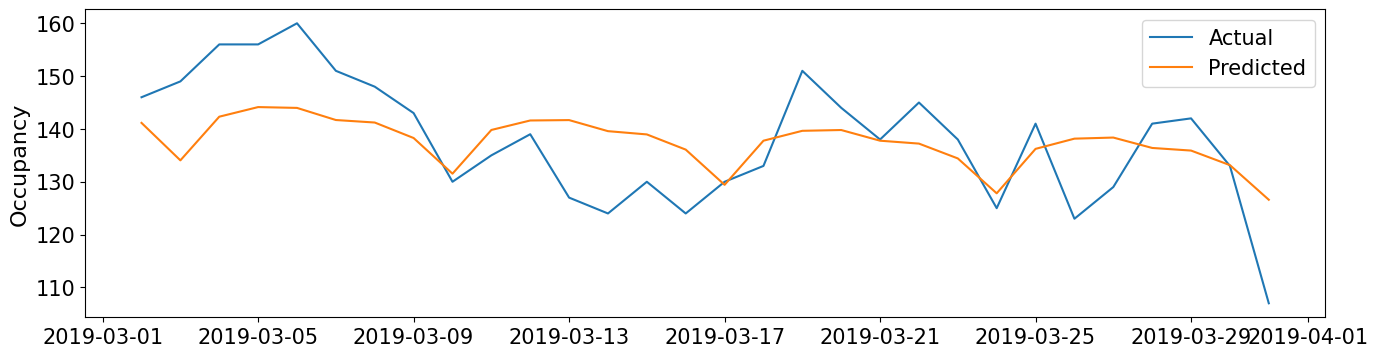

In [23]:
plt.figure(figsize=(16,4))
plt.plot(test_data, label="Actual") # No diff because we are working with stationary data
plt.plot(sarima_predictions_trained_data, label="Predicted")
plt.ylabel('Occupancy', fontsize=16)
plt.legend()

In [25]:
rmse = root_mean_squared_error(test_data[:30], sarima_predictions_trained_data)
mape = mean_absolute_percentage_error(test_data[:30], test_data)
[rmse, mape]

[9.551446859567788, 0.0]

In [26]:
rmse_scores = []
mape_scores = []

p = 2
d = 0
q = 0
P = 1
D = 0
Q = 2
m = 7

for train_index, test_index in tscv.split(df):
    train_data, test_data = df.iloc[train_index], df.iloc[test_index]
 
    model = SARIMAX(train_data['occupancy'],
                order=(p,d,q),
                seasonal_order=(P,D,Q,m))
    fitted_model = model.fit()
 
    predictions = fitted_model.forecast(steps=len(test_data))
 
    rmse = root_mean_squared_error(test_data, predictions)
    rmse_scores.append(rmse)

    mape = mean_absolute_percentage_error(test_data, predictions)
    mape_scores.append(mape)
 
    print(f'Root Mean Squared Error for current split: {rmse}')
    print(f'Mean Absolute  for current split: {rmse}')
 
# Calculate average Root Mean Squared Error across all splits
average_rmse = np.mean(rmse_scores)
print(f'Average Mean Squared Error across all splits: {average_rmse}')

# Calculate average Mean Absolute Percentage Error across all splits
average_mape = np.mean(mape_scores)
print(f'Average Mean Absolute Percentage across all splits: {average_mape}')

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.04734D+00    |proj g|=  8.32851D-01



 This problem is unconstrained.


At iterate    5    f=  3.52470D+00    |proj g|=  8.32014D-02

At iterate   10    f=  3.51065D+00    |proj g|=  6.57469D-03

At iterate   15    f=  3.50855D+00    |proj g|=  2.28506D-02

At iterate   20    f=  3.49973D+00    |proj g|=  8.68174D-03

At iterate   25    f=  3.49723D+00    |proj g|=  7.53242D-03

At iterate   30    f=  3.49219D+00    |proj g|=  3.75916D-02

At iterate   35    f=  3.48897D+00    |proj g|=  1.37396D-03

At iterate   40    f=  3.48897D+00    |proj g|=  4.09873D-05

At iterate   45    f=  3.48894D+00    |proj g|=  3.33883D-03

At iterate   50    f=  3.48886D+00    |proj g|=  5.57662D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf

/Users/alexandervalerian/Informatik/tha/intelligent-planning-of-care-staff/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.04470D+00    |proj g|=  8.05889D-01

At iterate    5    f=  3.53184D+00    |proj g|=  8.73495D-02

At iterate   10    f=  3.51664D+00    |proj g|=  1.74831D-03


 This problem is unconstrained.



At iterate   15    f=  3.51495D+00    |proj g|=  1.41238D-02

At iterate   20    f=  3.50831D+00    |proj g|=  1.36921D-03

At iterate   25    f=  3.50620D+00    |proj g|=  6.23778D-03

At iterate   30    f=  3.49967D+00    |proj g|=  3.30133D-03

At iterate   35    f=  3.49949D+00    |proj g|=  6.16661D-05

At iterate   40    f=  3.49948D+00    |proj g|=  2.41488D-03

At iterate   45    f=  3.49942D+00    |proj g|=  1.95456D-03

At iterate   50    f=  3.49941D+00    |proj g|=  7.11357D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     70      1     0     0   7.114D-04   3.499D+00
  F =   3.49940507937

/Users/alexandervalerian/Informatik/tha/intelligent-planning-of-care-staff/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.01194D+00    |proj g|=  7.87353D-01

At iterate    5    f=  3.52722D+00    |proj g|=  8.60961D-02

At iterate   10    f=  3.51200D+00    |proj g|=  7.28085D-03


 This problem is unconstrained.



At iterate   15    f=  3.51077D+00    |proj g|=  2.38346D-02

At iterate   20    f=  3.50366D+00    |proj g|=  8.75932D-03

At iterate   25    f=  3.50067D+00    |proj g|=  6.47993D-03

At iterate   30    f=  3.49548D+00    |proj g|=  2.59638D-02

At iterate   35    f=  3.49347D+00    |proj g|=  1.11190D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     37     43      1     0     0   2.591D-05   3.493D+00
  F =   3.4934710692721147     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Root Mean Squared Error for current split: 9.551446859567788
Mean Absolute  for current split: 9.551446859567788


In [7]:
# In the following the created model is being tested to ensure no overfitting has been done
# using public available data of critical care units
def parser(s):
    return datetime.strptime(s, '%Y-%m-%d')

df_landkreis = pd.read_csv('../../output/landkreise/09777.csv', usecols=['dates', 'occupancy'], index_col=0, parse_dates=[0])
df_landkreis.index.freq = 'D'
df_landkreis

,occupancy
dates,
2020-04-24,13
2020-04-25,10
2020-04-26,9
2020-04-27,8
2020-04-28,9
...,...
2024-04-15,10
2024-04-16,13
2024-04-17,15


In [8]:
# Splitting data into test and training data

train_data_landkreis = df_landkreis.iloc[:-30]
test_data_landkreis = df_landkreis.iloc[-30:]

In [9]:
# SARIMA prediction using optimal parameters

p = 2
d = 0
q = 0
P = 1
D = 0
Q = 2
m = 7

sarima = SARIMAX(train_data_landkreis['occupancy'],
                order=(p,d,q),
                seasonal_order=(P,D,Q,m))
model_fit_sarima_landkreis = sarima.fit()

forecast_steps = 30
sarima_predictions_trained_data_landkreis = model_fit_sarima_landkreis.forecast(steps=forecast_steps)

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.03735D+00    |proj g|=  5.35643D-02

At iterate    5    f=  2.00676D+00    |proj g|=  1.45157D-02

At iterate   10    f=  2.00486D+00    |proj g|=  1.27226D-03

At iterate   15    f=  2.00341D+00    |proj g|=  1.78252D-02

At iterate   20    f=  1.98704D+00    |proj g|=  6.47723D-02

At iterate   25    f=  1.97182D+00    |proj g|=  4.13709D-03

At iterate   30    f=  1.96765D+00    |proj g|=  3.13335D-02

At iterate   35    f=  1.95713D+00    |proj g|=  1.22948D-02

At iterate   40    f=  1.95465D+00    |proj g|=  3.34840D-03

At iterate   45    f=  1.95447D+00    |proj g|=  1.15814D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

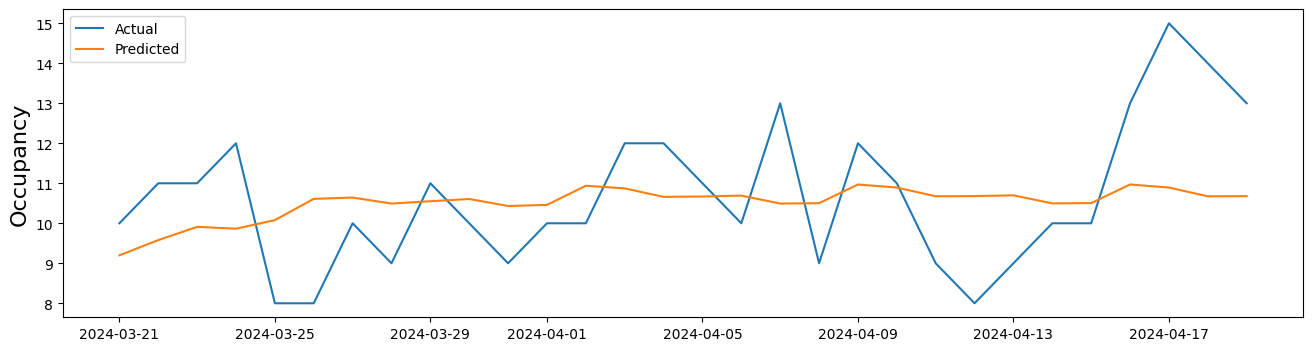

In [10]:
plt.figure(figsize=(16,4))
plt.plot(test_data_landkreis, label="Actual")
plt.plot(sarima_predictions_trained_data_landkreis, label="Predicted")
plt.ylabel('Occupancy', fontsize=16)
plt.legend()

In [14]:
rmse = root_mean_squared_error(test_data_landkreis[:30], sarima_predictions_trained_data_landkreis)
mape = mean_absolute_percentage_error(test_data_landkreis[:30], sarima_predictions_trained_data_landkreis)
[rmse, mape]

[1.7318947988612883, 0.13731115514897735]

In [15]:
tscv = TimeSeriesSplit(n_splits=3, test_size=30)

In [16]:
rmse_scores = []
mape_scores = []

p = 2
d = 0
q = 0
P = 1
D = 0
Q = 2
m = 7

for train_index, test_index in tscv.split(df_landkreis):
    train_data, test_data = df_landkreis.iloc[train_index], df_landkreis.iloc[test_index]
 
    model = SARIMAX(train_data['occupancy'],
                order=(p,d,q),
                seasonal_order=(P,D,Q,m))
    fitted_model = model.fit()
 
    predictions = fitted_model.forecast(steps=len(test_data))
 
    rmse = root_mean_squared_error(test_data, predictions)
    rmse_scores.append(rmse)

    mape = mean_absolute_percentage_error(test_data, predictions)
    mape_scores.append(mape)
 
    print(f'Root Mean Squared Error for current split: {rmse}')
    print(f'Mean Absolute  for current split: {rmse}')
 
# Calculate average Root Mean Squared Error across all splits
average_rmse = np.mean(rmse_scores)
print(f'Average Mean Squared Error across all splits: {average_rmse}')

# Calculate average Mean Absolute Percentage Error across all splits
average_mape = np.mean(mape_scores)
print(f'Average Mean Absolute Percentage across all splits: {average_mape}')

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.04411D+00    |proj g|=  5.76163D-02

At iterate    5    f=  2.01540D+00    |proj g|=  8.35829D-03

At iterate   10    f=  2.01444D+00    |proj g|=  2.47341D-03

At iterate   15    f=  1.98788D+00    |proj g|=  6.61394D-02

At iterate   20    f=  1.97748D+00    |proj g|=  3.69661D-03

At iterate   25    f=  1.96918D+00    |proj g|=  1.63387D-02

At iterate   30    f=  1.96172D+00    |proj g|=  3.20242D-03

At iterate   35    f=  1.96117D+00    |proj g|=  2.46653D-04

At iterate   40    f=  1.96117D+00    |proj g|=  5.49460D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.



At iterate   10    f=  2.01119D+00    |proj g|=  1.28602D-03

At iterate   15    f=  2.00907D+00    |proj g|=  2.01403D-02

At iterate   20    f=  1.99504D+00    |proj g|=  1.41805D-01

At iterate   25    f=  1.97546D+00    |proj g|=  6.11501D-03

At iterate   30    f=  1.97395D+00    |proj g|=  2.09480D-02

At iterate   35    f=  1.96220D+00    |proj g|=  8.96159D-03

At iterate   40    f=  1.96026D+00    |proj g|=  3.06165D-03

At iterate   45    f=  1.96000D+00    |proj g|=  7.80462D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     47     66      1     0     0   7.798D-06   1.960D+00
  F =   1.95999898564

 This problem is unconstrained.


At iterate   10    f=  2.00486D+00    |proj g|=  1.27226D-03

At iterate   15    f=  2.00341D+00    |proj g|=  1.78252D-02

At iterate   20    f=  1.98704D+00    |proj g|=  6.47723D-02

At iterate   25    f=  1.97182D+00    |proj g|=  4.13709D-03

At iterate   30    f=  1.96765D+00    |proj g|=  3.13335D-02

At iterate   35    f=  1.95713D+00    |proj g|=  1.22948D-02

At iterate   40    f=  1.95465D+00    |proj g|=  3.34840D-03

At iterate   45    f=  1.95447D+00    |proj g|=  1.15814D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     47     64      1     0     0   1.700D-05   1.954D+00
  F =   1.954467418633